In [11]:
cd /usr/users/ga004/buntingd/FP_dev/data/0.3

/usr/users/ga004/buntingd/FP_dev/data/0.3


In [390]:
import vcfnp
import numpy as np
import h5py
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

import allel
import seaborn as sns
import pandas as pd

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score,calinski_harabaz_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

from fieldpathogenomics.utils import reference_dir

%matplotlib inline
sns.set_style('whitegrid')
mpl.rcParams['figure.figsize'] = (10, 6)

In [7]:
callset = h5py.File('Callset/2013/2013_filtered.hd5', mode='r')
genotypes = allel.GenotypeChunkedArray(callset['calldata']['GT'])
variants = allel.VariantChunkedTable(callset['variants'])
samples = list(callset['samples'])

# Calculate the site coverage of each gene

In [238]:
genes = allel.FeatureTable.from_gff3(os.path.join(reference_dir, 'PST_genes_final.gff3'), attributes=['ID']).query("type == 'gene'")

sorted_idx = np.lexsort( (variants['POS'], variants['CHROM']))
index = allel.SortedMultiIndex(variants['CHROM'][:][sorted_idx], variants['POS'][:][sorted_idx])
called = genotypes.is_called()[:][sorted_idx]
is_snp = np.logical_and(called, ~genotypes.is_hom_ref()[:][sorted_idx])
is_het = np.logical_and(called, genotypes.is_het()[:][sorted_idx])

gene_coverage = np.zeros((len(genes), len(samples)))
gene_snp_rate = np.zeros((len(genes), len(samples)))
gene_het_rate = np.zeros((len(genes), len(samples)))

for i, g in enumerate(genes):
    try:
        called_sites = called[index.locate_range(g[0], g[3], g[4])].sum(axis=0)
        gene_coverage[i] = called_sites / (g[4] - g[3])
        if gene_coverage[i] < 0.8: 
            continue
        gene_snp_rate[i] = is_snp[index.locate_range(g[0], g[3], g[4])].sum(axis=0) / called_sites
        gene_het_rate[i] = is_snp[index.locate_range(g[0], g[3], g[4])].sum(axis=0) / called_sites
        
    except KeyError:
        pass
    
gene_coverage = pd.DataFrame(gene_coverage, columns=samples, index=genes['ID'])
gene_snp_rate = pd.DataFrame(gene_snp_rate, columns=samples, index=genes['ID'])
gene_het_rate = pd.DataFrame(gene_het_rate, columns=samples, index=genes['ID'])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [209]:
gene_snp = pd.concat([gene_coverage, gene_snp_rate, gene_het_rate], keys=['cov',  'snps', 'het'], axis=1).swaplevel(axis=1)
gene_snp.head()

,LIB4360,LIB4361,LIB4362,LIB4456,LIB4457,LIB4458,LIB4459,LIB4460,LIB4462,LIB4463,...,LIB4483,LIB4745,LIB4746,LIB4747,LIB4748,LIB5291,LIB5292,LIB5293,LIB5294,LIB5295
,cov,cov,cov,cov,cov,cov,cov,cov,cov,cov,...,het,het,het,het,het,het,het,het,het,het
XLOC_000001,0.792541,0.777458,0.679282,0.778829,0.796654,0.421637,0.797340,0.771013,0.800219,0.794049,...,0.006545,0.000000,0.006000,0.000000,0.000000,0.011071,0.015880,0.016644,0.005148,0.006852
XLOC_000002,0.705823,0.704819,0.701807,0.705823,0.707329,0.699799,0.705321,0.702811,0.700301,0.707329,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
XLOC_000003,0.579175,0.588292,0.574376,0.575816,0.575336,0.584453,0.577735,0.573896,0.583493,0.582534,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
XLOC_000004,0.091468,0.096080,0.083013,0.099154,0.106072,0.098386,0.092237,0.081476,0.107610,0.093774,...,0.025210,0.007634,0.034335,0.007752,0.008197,0.012987,0.000000,NaN,0.037313,0.051724
XLOC_000005,0.680010,0.637756,0.640227,0.669632,0.732889,0.646158,0.676798,0.657030,0.707438,0.687176,...,0.028232,0.001085,0.013365,0.001103,0.000909,0.028468,0.030287,0.036062,0.007108,0.015643


# Load the Kallisto expression levels

In [35]:
transcript_expression = pd.read_table("Expression/2013/kallisto_abundances.tsv", sep='\t', index_col=0, header=[0,1])
transcript_expression.head()

LIB4360                 LIB4361               \
                            std          tpm        std          tpm   
TCONS_00000004|m.1    34.585771   745.993317  28.590891   614.072181   
TCONS_00000005|m.2    45.675287  1308.596683  47.160291  1643.207819   
TCONS_00000006|m.4    47.460901  2145.770000  55.635388  2645.940000   
TCONS_00000001|m.12  102.366988   248.361353   0.002745     0.007999   
TCONS_00000001|m.13  102.366988   248.361353   0.002745     0.007999   

                        LIB4362                  LIB4456               \
                            std          tpm         std          tpm   
TCONS_00000004|m.1    18.523642   313.221953   38.687676  1147.813680   
TCONS_00000005|m.2    31.021536   798.488047   42.294990  1485.586320   
TCONS_00000006|m.4    42.506822  2121.010000   43.178989  1691.430000   
TCONS_00000001|m.12  102.519636   180.782597  137.669835   382.386738   
TCONS_00000001|m.13  102.519636   180.782597  137.669835   382.386738   

                       LIB4457                  ...         LIB5291  \
                           std          tpm     ...             std   
TCONS_00000004|m.1   37.689591  1066.618425     ...       19.673555   
TCONS_00000005|m.2   42.533801  1390.981575     ...       25.435323   
TCONS_00000006|m.4   41.417223  1830.560000     ...       34.283967   
TCONS_00000001|m.12  58.787103    78.851032     ...        0.000029   
TCONS_00000001|m.13  58.787103    78.851032     ...        0.000029   

                                    LIB5292                 LIB5293  \
                             tpm        std          tpm        std   
TCONS_00000004|m.1    293.502366  10.717621    75.109383  11.034556   
TCONS_00000005|m.2    527.927634  18.998606   421.150617  18.798875   
TCONS_00000006|m.4   1457.360000  35.105867  1482.910000  23.418121   
TCONS_00000001|m.12     0.009852  49.689706    49.404521  71.967303   
TCONS_00000001|m.13     0.009852  49.689706    49.404521  71.967303   

                                    LIB5294                 LIB5295  \
                            tpm         std          tpm        std   
TCONS_00000004|m.1    85.080792   41.885263  1600.612695  32.028861   
TCONS_00000005|m.2   277.669208   30.928350   687.087305  27.186281   
TCONS_00000006|m.4   876.540000   52.110886  2394.340000  43.794406   
TCONS_00000001|m.12   88.650632  103.511721   252.027040  53.331899   
TCONS_00000001|m.13   88.650632  103.511721   252.027040  53.331899   

                                  
                             tpm  
TCONS_00000004|m.1   1009.415717  
TCONS_00000005|m.2    658.874283  
TCONS_00000006|m.4   2200.100000  
TCONS_00000001|m.12    53.685351  
TCONS_00000001|m.13    53.685351  

[5 rows x 74 columns]

In [38]:
transcript_to_gene = allel.FeatureTable.from_gff3(os.path.join(reference_dir, 'PST_genes_final.gff3'), attributes=['ID', 'Parent']).query("type == 'mRNA'")[['ID', 'Parent']]

/usr/users/ga004/buntingd/FP_dev/dev/lib/python3.5/site-packages/numpy/core/records.py:507: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.13 because this will return a view instead of a copy -- see release notes for details.
  return obj.view(dtype=(self.dtype.type, obj.dtype))


In [84]:
m = pd.merge(transcript_expression.reset_index(), pd.DataFrame(transcript_to_gene.values), left_on='index', right_on='ID').drop([('index', ''), 'ID'], axis=1).set_index('Parent')
m.columns = pd.MultiIndex.from_tuples(m.columns)
tpms = m.xs('tpm', axis=1, level=1).groupby('Parent').sum()
stds = m.xs('std', axis=1, level=1).groupby('Parent').agg(lambda x: np.sqrt(np.sum(x**2)))
gene_expression = pd.concat([tpms, stds], keys=['tpm',  'std'], axis=1).swaplevel(axis=1)

/usr/users/ga004/buntingd/FP_dev/dev/lib/python3.5/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [85]:
gene_expression.head()

,LIB4360,LIB4361,LIB4362,LIB4456,LIB4457,LIB4458,LIB4459,LIB4460,LIB4462,LIB4463,...,LIB4483,LIB4745,LIB4746,LIB4747,LIB4748,LIB5291,LIB5292,LIB5293,LIB5294,LIB5295
,tpm,tpm,tpm,tpm,tpm,tpm,tpm,tpm,tpm,tpm,...,std,std,std,std,std,std,std,std,std,std
Parent,,,,,,,,,,,,,,,,,,,,,
XLOC_000001,10052.89,3562.45,13791.26,8312.85,6990.96,2050.54,6970.55,12349.18,13160.74,11804.04,...,225.748789,270.562487,168.931743,56.240854,31.114532,73.913702,130.429602,157.324796,225.750130,135.935755
XLOC_000002,2054.59,2257.28,1111.71,2633.40,2457.60,1083.55,1953.44,1097.54,2048.65,2325.96,...,60.884432,45.703305,60.272903,35.694928,18.496539,32.155939,21.813171,21.798145,52.066669,42.011211
XLOC_000003,2145.77,2645.94,2121.01,1691.43,1830.56,2094.38,1742.26,2093.61,1731.24,2031.07,...,50.804134,36.442283,57.332779,30.735769,19.255158,34.283967,35.105867,23.418121,52.110886,43.794406
XLOC_000005,1029.47,840.82,547.47,725.98,1125.53,607.50,632.40,529.65,793.69,630.81,...,22.151500,20.139369,26.574729,16.998823,8.121364,14.234788,10.537673,9.755757,18.499032,14.729350
XLOC_000006,436.69,822.98,605.45,460.23,794.84,325.49,618.99,795.40,719.41,282.08,...,52.198947,38.087000,45.164821,31.252027,26.857718,21.127512,19.778086,23.854102,31.795673,29.348501


In [210]:
merged = pd.merge(gene_expression, gene_snp, right_index=True, left_index=True)
merged.columns.names = ['Library', 'col1']
merged.head()

Library,LIB4360,LIB4361,LIB4362,LIB4456,LIB4457,LIB4458,LIB4459,LIB4460,LIB4462,LIB4463,...,LIB4483,LIB4745,LIB4746,LIB4747,LIB4748,LIB5291,LIB5292,LIB5293,LIB5294,LIB5295
col1,tpm,tpm,tpm,tpm,tpm,tpm,tpm,tpm,tpm,tpm,...,het,het,het,het,het,het,het,het,het,het
XLOC_000001,10052.89,3562.45,13791.26,8312.85,6990.96,2050.54,6970.55,12349.18,13160.74,11804.04,...,0.006545,0.000000,0.006000,0.000000,0.000000,0.011071,0.015880,0.016644,0.005148,0.006852
XLOC_000002,2054.59,2257.28,1111.71,2633.40,2457.60,1083.55,1953.44,1097.54,2048.65,2325.96,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
XLOC_000003,2145.77,2645.94,2121.01,1691.43,1830.56,2094.38,1742.26,2093.61,1731.24,2031.07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
XLOC_000005,1029.47,840.82,547.47,725.98,1125.53,607.50,632.40,529.65,793.69,630.81,...,0.028232,0.001085,0.013365,0.001103,0.000909,0.028468,0.030287,0.036062,0.007108,0.015643
XLOC_000006,436.69,822.98,605.45,460.23,794.84,325.49,618.99,795.40,719.41,282.08,...,0.005768,0.000000,0.005097,0.000000,0.000000,0.007237,0.006486,0.008634,0.004274,0.005510


# Variant detection power with expression

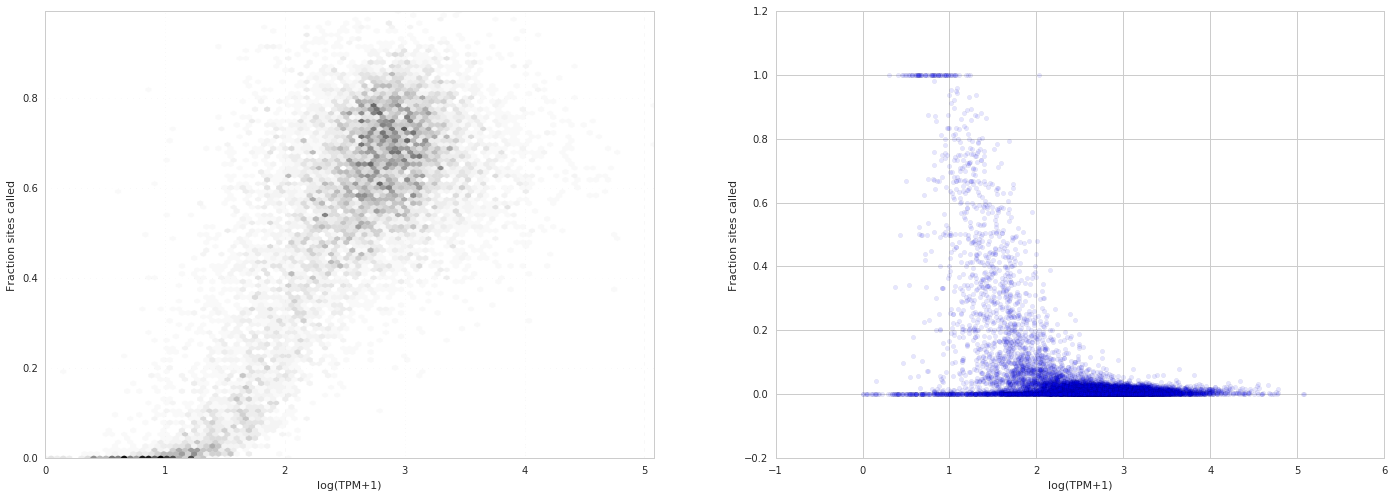

In [276]:
plt.figure(figsize=(24, 8))

#sns.kdeplot(np.log10(merged.xs('tpm', level=1, axis=1).mean(axis=1)+1), merged.xs('cov', level=1, axis=1).mean(axis=1), ax=plt.subplot(121))
plt.subplot(121).hexbin(np.log10(merged.xs('tpm', level=1, axis=1).mean(axis=1)+1), merged.xs('cov', level=1, axis=1).mean(axis=1))
plt.subplot(121).set_xlabel('log(TPM+1)')
plt.subplot(121).set_ylabel('Fraction sites called')

plt.subplot(122).scatter(np.log10(merged.xs('tpm', level=1, axis=1).mean(axis=1)+1), merged.xs('het', level=1, axis=1).mean(axis=1), alpha=0.1)
plt.subplot(122).set_xlabel('log(TPM+1)')
#plt.subplot(122).set_ylim((0,0.2))


plt.subplot(122).set_ylabel('Fraction sites called')

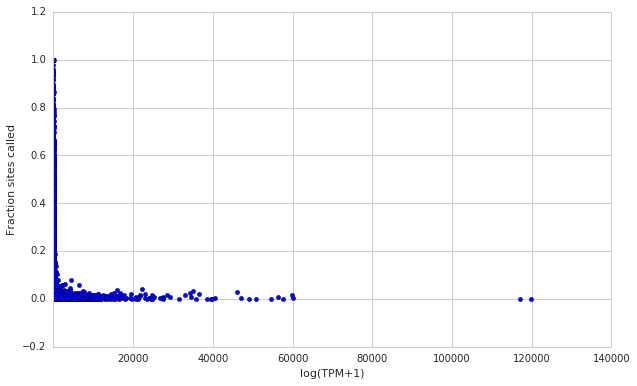

In [237]:
plt.scatter(merged.xs('tpm', level=1, axis=1).mean(axis=1), merged.xs('snps', level=1, axis=1).mean(axis=1))
plt.xlabel('log(TPM+1)')
plt.xlim((10,None))
plt.ylabel('Fraction sites called')

(1, 411732.2865118811)

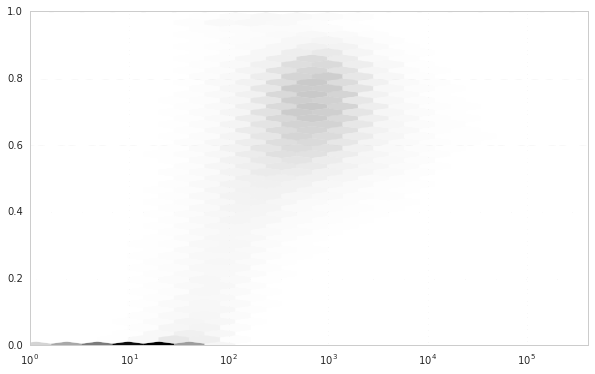

In [273]:
melt = merged.stack(level=0).reset_index()
plt.hexbin(melt[melt['tpm']>0]['tpm'], melt[melt['tpm']>0]['cov'], xscale='log', gridsize=50)
plt.xlim((1, None))

In [310]:
groups = np.array([['LIB4360', '0'], ['LIB4361', '3'], ['LIB4362', '0'], ['LIB4456', '0'], ['LIB4457', '1'], ['LIB4458', '0'], ['LIB4459', '3'], ['LIB4460', '0'], ['LIB4462', '1'], ['LIB4463', '0'], ['LIB4465', '0'], ['LIB4466', '1'], ['LIB4467', '1'], ['LIB4468', '3'], ['LIB4470', '0'], ['LIB4471', '0'], ['LIB4472', '0'], ['LIB4473', '0'], ['LIB4474', '3'], ['LIB4475', '0'], ['LIB4476', '3'], ['LIB4477', '0'], ['LIB4478', '0'], ['LIB4479', '0'], ['LIB4480', '3'], ['LIB4481', '3'], ['LIB4482', '0'], ['LIB4483', '2'], ['LIB4745', '1'], ['LIB4746', '0'], ['LIB4747', '1'], ['LIB4748', '1'], ['LIB5291', '2'], ['LIB5292', '2'], ['LIB5293', '2'], ['LIB5294', '0'], ['LIB5295', '3']], dtype=object)
groups = pd.DataFrame(groups, columns=['sample', 'group'])
groups.head()

,sample,group
0,LIB4360,0
1,LIB4361,3
2,LIB4362,0
3,LIB4456,0
4,LIB4457,1


# PCA Expression Data

This seems to show that it's not possible to distinguish the genetic groups based on gene expression.
Indeed doesn't appear to be discrete groups in the data, but there is structure, low PCs are able to capture a lot of variance.

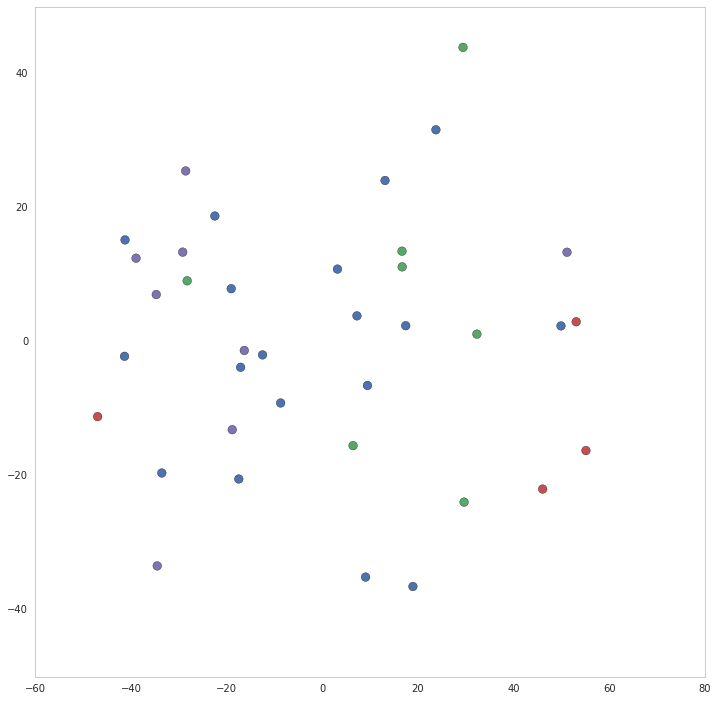

In [407]:
tpm = np.array(gene_expression.xs('tpm', axis=1, level=1))
tpm[tpm < 10] = 0
tpm = tpm[(tpm > 0).mean(axis=1) > 0.8, :]

X = scale(tpm, with_std=True, with_mean=True)
pca = PCA(100)
Y = pca.fit_transform(X.T)

plt.figure(figsize=(12, 12))
plt.scatter(Y[:,0], Y[:,1], c=[sns.color_palette(n_colors=4)[int(i)] for i in groups['group']], s=75)
plt.grid()

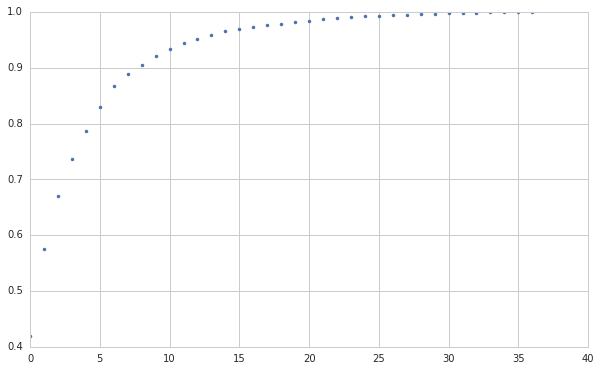

In [393]:
plt.plot(np.cumsum(pca.explained_variance_/pca.explained_variance_.sum()), '.')

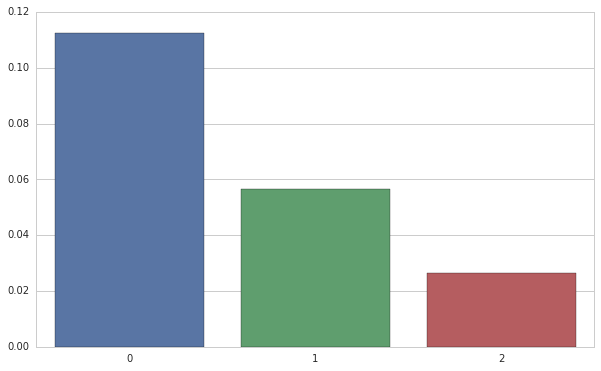

In [396]:
lda = LinearDiscriminantAnalysis(solver='eigen', tol=1e-17, shrinkage='auto')

Z = PCA(10).fit_transform(X.T)
lda.fit(Z, groups['group'])

sns.barplot(list(range(len(lda.explained_variance_ratio_))), lda.explained_variance_ratio_**2)

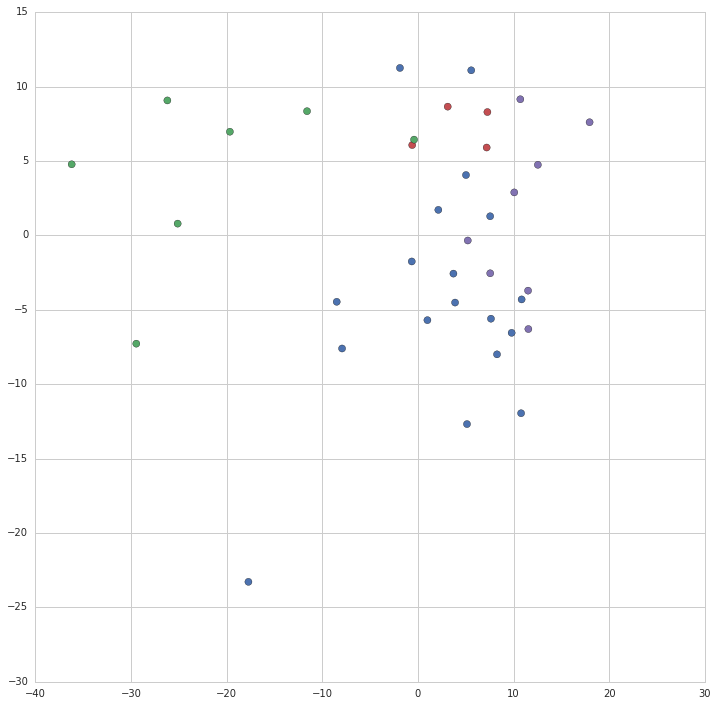

In [397]:
plt.figure(figsize=(12,12))
plt.scatter(x=lda.transform(Z)[:, 0], y=lda.transform(Z)[:, 1], c=[sns.color_palette(n_colors=4)[int(i)] for i in groups['group']], marker='o', s=50)

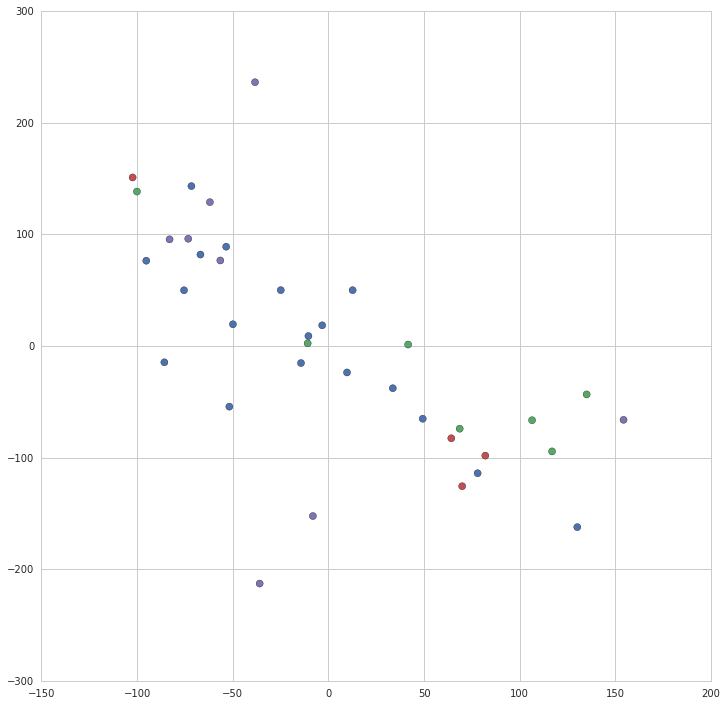

In [405]:
tsne = TSNE(perplexity=10)
plt.figure(figsize=(12, 12))
plt.scatter(x=tsne.fit_transform(X.T)[:, 0], y=tsne.fit_transform(X.T)[:, 1], c=[sns.color_palette(n_colors=4)[int(i)] for i in groups['group']], marker='o', s=50)